# Health failure prediction using Machine Learning

## Machine Learning workflow

### Project setup

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, precision_score
from scipy.stats import sem, t
from sklearn.base import clone

In [2]:
data_dir = "../../data/"
train_data_path = data_dir + "train.csv"
test_data_path = data_dir + "test.csv"

models_dir = "../../models/"
os.makedirs(models_dir, exist_ok=True)

### Utility functions

#### Methods:

* The `preprocess_data` function is used to load the training and test datasets. It encodes categorical features and normalizes numerical features based on the specified encoding method (`LabelEncoder` or `One-Hot`). It also handles optional feature exclusion, ensuring that specified columns are removed from the datasets.

* The `define_models` function defines a set of ML models (RandomForest, SVM, and LogisticRegression) along with their hyperparameters.

* The `evaluate_models` function performs grid search cross-validation to find the best hyperparameters for each model. It calculates the mean F1 score and accuracy, along with their standard deviations and confidence intervals.

* The `display_results` function prints the evaluation results for each model in a readable format. This includes the best hyperparameters, mean F1 score, mean accuracy, standard deviations, and confidence intervals for each model.

In [3]:
def preprocess_data(train_data_path, test_data_path, encoding_method='label', fts_exclude=None):
    """
    Preprocesses the data by encoding categorical features and normalizing numerical features.
    
    Parameters:
    - train_data_path: str, path to the training data CSV file
    - test_data_path: str, path to the test data CSV file
    - encoding_method: str, method to encode categorical features ('label' or 'onehot')
    
    Returns:
    - X_train: DataFrame, preprocessed training features
    - X_test: DataFrame, preprocessed test features
    - y_train: Series, training target
    - y_test: Series, test target
    - preprocessor: ColumnTransformer, the preprocessing transformer to be used in pipelines
    """
    target_column = "HeartDisease"

    trainDF = pd.read_csv(train_data_path)
    testDF = pd.read_csv(test_data_path)

    X_train = trainDF.drop(columns=target_column)
    y_train = trainDF[target_column]

    X_test = testDF.drop(columns=target_column)
    y_test = testDF[target_column]

    # Categorical features
    categorical = trainDF.drop(columns=target_column).select_dtypes(include=['object']).columns

    # if fts_exclude is list
    if fts_exclude:
        X_train = X_train.drop(columns=fts_exclude)
        X_test = X_test.drop(columns=fts_exclude)

        # Update categorical features
        categorical = X_train.select_dtypes(include=['object']).columns

    if encoding_method == 'label':
        label_encoders = {}
        for feature in categorical:
            le = LabelEncoder()
            X_train[feature] = le.fit_transform(X_train[feature])
            X_test[feature] = le.transform(X_test[feature])
            label_encoders[feature] = le

        preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), list(X_train.columns.difference(categorical + [target_column]))),
            ('cat', 'passthrough', list(categorical))
        ])

    elif encoding_method == 'onehot':
        label_encoders = None
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), X_train.select_dtypes(include=['int64', 'float64']).columns),
                ('cat', OneHotEncoder(), categorical)
            ]
        )

    return X_train, X_test, y_train, y_test, preprocessor, label_encoders

def define_models():
    """
    Defines the models and their hyperparameters for grid search.
    
    Returns:
    - models: dict, a dictionary containing model configurations and hyperparameters
    """
    models = {
        'RandomForest': {
            'model': RandomForestClassifier(),
            'params': {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [None, 10, 20]
            }
        },
        'SVM': {
            'model': SVC(probability=True),
            'params': {
                'classifier__C': [0.1, 1, 10],
                'classifier__gamma': [1, 0.1, 0.01],
                'classifier__kernel': ['linear', 'rbf']
            }
        },
        'LogisticRegression': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'classifier__C': [0.1, 1, 10]
            }
        }
    }
    return models

def evaluate_models(models, X_train, y_train, preprocessor):
    """
    Evaluates the models using grid search and cross-validation, and calculates performance metrics.
    
    Parameters:
    - models: dict, a dictionary containing model configurations and hyperparameters
    - X_train: DataFrame, preprocessed training features
    - y_train: Series, training target
    - preprocessor: ColumnTransformer, the preprocessing transformer to be used in pipelines
    
    Returns:
    - results: dict, a dictionary containing evaluation results for each model
    """
    results = {}
    for model_name, config in models.items():
        clf = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', config['model'])
        ])
        
        grid_search = GridSearchCV(clf, config['params'], cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        
        cv_results = cross_val_score(clone(best_model), X_train, y_train, cv=5, scoring='f1')
        mean_f1 = np.mean(cv_results)
        std_f1 = np.std(cv_results)
        confidence_interval_f1 = t.interval(0.95, len(cv_results)-1, loc=mean_f1, scale=sem(cv_results))
        
        cv_results_acc = cross_val_score(clone(best_model), X_train, y_train, cv=5, scoring='accuracy')
        mean_acc = np.mean(cv_results_acc)
        std_acc = np.std(cv_results_acc)
        confidence_interval_acc = t.interval(0.95, len(cv_results_acc)-1, loc=mean_acc, scale=sem(cv_results_acc))
        
        results[model_name] = {
            'best_params': best_params,
            'mean_f1': mean_f1,
            'std_f1': std_f1,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'confidence_interval_f1': confidence_interval_f1,
            'confidence_interval_accuracy': confidence_interval_acc,
        }
    
    return results

def display_results(results):
    """
    Prints the evaluation results for each model.
    
    Parameters:
    - results: dict, a dictionary containing evaluation results for each model
    """
    for model_name, result in results.items():
        print(f"    Model: {model_name}")
        print(f"        Best Hyperparameters: {result['best_params']}")
        print(f"        Mean F1 Score: {result['mean_f1']}")
        print(f"        Standard Deviation of F1 Score: {result['std_f1']}")
        print(f"        Mean Accuracy: {result['mean_accuracy']}")
        print(f"        Standard Deviation of Accuracy: {result['std_accuracy']}")
        print(f"        95% Confidence Interval for F1 Score: {result['confidence_interval_f1']}")
        print(f"        95% Confidence Interval for Accuracy: {result['confidence_interval_accuracy']}")
        print("\n")

### Machine Learning models and hyperparameters

In [4]:
models = define_models()
print("Models and hyperparameters:")
for model in models:
    print(model)
    print(models[model])

Models and hyperparameters:
RandomForest
{'model': RandomForestClassifier(), 'params': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [None, 10, 20]}}
SVM
{'model': SVC(probability=True), 'params': {'classifier__C': [0.1, 1, 10], 'classifier__gamma': [1, 0.1, 0.01], 'classifier__kernel': ['linear', 'rbf']}}
LogisticRegression
{'model': LogisticRegression(max_iter=1000), 'params': {'classifier__C': [0.1, 1, 10]}}


### Evaluation

In [5]:
cat_encoding = ["onehot", "label"]
fts_exclude = [None, "RestingBP", "RestingECG", "all"]

for f in fts_exclude:

    if f == "all":
        to_exclude = [f for f in fts_exclude if f != "all" and f != None]
    else:
        to_exclude = f

    for c in cat_encoding:
        print("Evaluation with encoding method: ", c , " and features excluded: ", to_exclude)
        X_train, X_test, y_train, y_test, preprocessor, label_encoding = preprocess_data(train_data_path, test_data_path, encoding_method=c, fts_exclude=to_exclude)
        results = evaluate_models(models, X_train, y_train, preprocessor)
        display_results(results)

Evaluation with encoding method:  onehot  and features excluded:  None
    Model: RandomForest
        Best Hyperparameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 200}
        Mean F1 Score: 0.8765362816111282
        Standard Deviation of F1 Score: 0.019354925431861642
        Mean Accuracy: 0.8678221973720994
        Standard Deviation of Accuracy: 0.021938480492179172
        95% Confidence Interval for F1 Score: (0.8496673376227478, 0.9034052255995085)
        95% Confidence Interval for Accuracy: (0.8373667039831053, 0.8982776907610935)


    Model: SVM
        Best Hyperparameters: {'classifier__C': 0.1, 'classifier__gamma': 1, 'classifier__kernel': 'linear'}
        Mean F1 Score: 0.8789344972302491
        Standard Deviation of F1 Score: 0.020078066027360487
        Mean Accuracy: 0.8637126083310036
        Standard Deviation of Accuracy: 0.02682304994555019
        95% Confidence Interval for F1 Score: (0.8510616731584975, 0.9068073213020007)
        95% Co

### Model selection

Model selection factors:

1. **Performance Metrics:**
   - F1 Score, Accuracy, and their confidence intervals.
   - Standard deviations to understand the consistency of the model's performance.

2. **Model Complexity:**
   - Complexity and interpretability of the model: Logistic Regression is simpler and more interpretable than SVM or RandomForest.

#### Evaluation summary

1. **SVM with One-Hot Encoding and Excluding `RestingBP`:**
   - **Mean F1 Score:** 0.8824
   - **Mean Accuracy:** 0.8664
   - **Best Hyperparameters:** `{'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}`

2. **Logistic Regression with One-Hot Encoding:**
   - **Mean F1 Score:** 0.8804
   - **Mean Accuracy:** 0.8651
   - **Best Hyperparameters:** `{'classifier__C': 0.1}`

3. **RandomForest with One-Hot Encoding:**
   - **Mean F1 Score:** 0.8803
   - **Mean Accuracy:** 0.8651
   - **Best Hyperparameters:** `{'classifier__max_depth': 10, 'classifier__n_estimators': 100}`

#### Final Decision

Given the performance metrics and considering that performance is critical for a healthcare problem, SVM with One-Hot Encoding and Excluding RestingBP is recommended for deployment.

- **High Performance**: SVM with One-Hot Encoding and excluding RestingBP achieved the highest mean F1 score and mean accuracy among the evaluated models.
- **Healthcare Priority**: In healthcare applications, higher performance in terms of predictive accuracy is more important than model complexity.
- **Robustness**: The chosen SVM model with the specified configuration showed strong and consistent performance, making it suitable for deployment in critical healthcare settings.

#### Best model training

In [6]:
trainDF = pd.read_csv(train_data_path)
testDF = pd.read_csv(test_data_path)

target_column = "HeartDisease"

X_train = trainDF.drop(columns=target_column)
y_train = trainDF[target_column]

X_test = testDF.drop(columns=target_column)
y_test = testDF[target_column]

exlude = "RestingBP"
X_train = X_train.drop(columns=exlude)

# Categorical features
categorical = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.columns[:-1].difference(categorical)),
        ('cat', OneHotEncoder(), categorical)
        ])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(C=1, gamma=0.1, kernel='rbf', probability=True))
])

clf.fit(X_train, y_train)

# Save the model
model_path = os.path.join(models_dir, "best_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(clf, f)

#### Selected model test

Confusion Matrix:
[[68 14]
 [ 9 93]]
Accuracy: 0.875
F1 Score: 0.8899521531100477
Precision: 0.8691588785046729
Recall: 0.9117647058823529
ROC-AUC: 0.9186991869918699

Class-wise Metrics:

                 precision    recall  f1-score   support

No HeartDisease       0.88      0.83      0.86        82
   HeartDisease       0.87      0.91      0.89       102

       accuracy                           0.88       184
      macro avg       0.88      0.87      0.87       184
   weighted avg       0.88      0.88      0.87       184



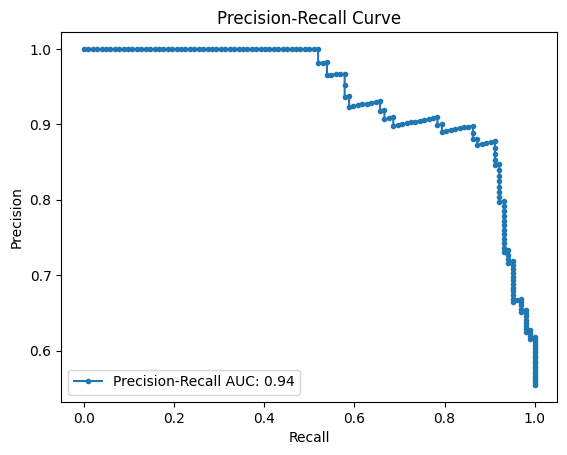

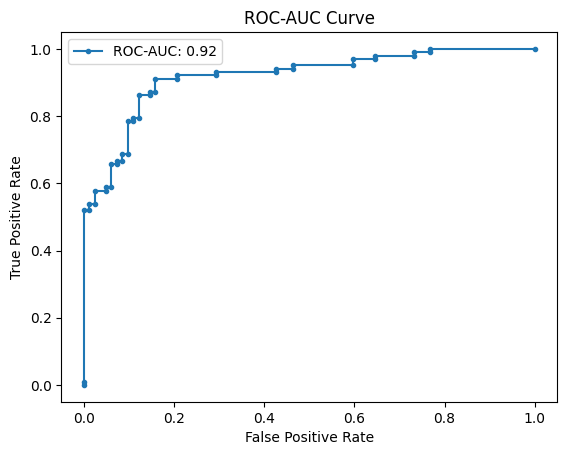

In [7]:
# Load the model
with open(model_path, "rb") as f:
    clf = pickle.load(f)

# Predict on the test set
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Generate class-wise metrics
class_report = classification_report(y_test, y_pred, target_names=['No HeartDisease', 'HeartDisease'])

# Print the metrics
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC: {roc_auc}")
print("\nClass-wise Metrics:\n")
print(class_report)

# Plot Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall_vals, precision_vals)

plt.figure()
plt.plot(recall_vals, precision_vals, marker='.', label=f'Precision-Recall AUC: {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, marker='.', label=f'ROC-AUC: {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()

#### Summary

The model correctly identified 69 instances of "No HeartDisease" and 92 instances of "HeartDisease", with 13 false positives and 10 false negatives. In addition, classifier achieved an accuracy of 87.5%, indicating a high overall correctness in classification. An F1 score of 0.889 reflects a good balance between precision and recall, making the model reliable in distinguishing between positive and negative cases. With a precision of 0.876 and recall of 0.902, the model shows it can effectively identify most "HeartDisease" cases while maintaining a high rate of correct positive predictions. The ROC-AUC score of 0.9255 indicates excellent discrimination ability between the classes.